<a href="https://colab.research.google.com/github/edmenciab733/hackaton2023/blob/main/diagnostico_trastornos_edgar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerías 

Se instalan las librerías necesarias
- datasets
- ntlk 
- transformers
- peft


In [1]:
!pip install -q bitsandbytes datasets accelerate loralib
!pip install nltk
!pip install -q git+https://github.com/huggingface/transformers.git@main git+https://github.com/huggingface/peft.git
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 KB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 28.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing

Se cargan las librerías necesariás

In [39]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
import numpy as np
from datasets import load_metric
from transformers import Trainer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
import evaluate
from sklearn import metrics
import matplotlib.pyplot as plt

# Dataset
- Se carga stopwords
- Se carga el dataset Sintomas.xlsx
- Se convierte el los padecimientos en una variable númerica llamada Padecimiento_Cat
- Se crean los diccionarios  id2label - label2id para que el pipeline dé los resultados
- Se define el numero de posibles resultados

In [3]:
%%capture
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [31]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

worksheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/1EOAx7_OmuKArEo-vM9NaMOXDPVtk3hjOwpcLX4rYnUI/edit#gid=0').sheet1

data = pd.DataFrame.from_records(worksheet.get_all_values())
data.columns = data.iloc[0]
data = data.drop(data.index[0])

In [32]:
data.head()

,Síntoma,Padecimiento
1,"Desde que era joven, ha tenido la creencia de ...",Trastornos de la personalidad esquizotípica
2,Tiene la superstición de que si no sigue ciert...,Trastornos de la personalidad esquizotípica
3,"A menudo experimenta ilusiones corporales, com...",Trastornos de la personalidad esquizotípica
4,"Su discurso a menudo es vago y metafórico, lo ...",Trastornos de la personalidad esquizotípica
5,Tiene la tendencia a pensar que las personas a...,Trastornos de la personalidad esquizotípica


In [33]:
labelencoder = LabelEncoder()
labelencoder.fit(data['Padecimiento'])
data['Padecimiento_Cat'] = labelencoder.transform(data['Padecimiento'])

In [34]:
id2label = {}
label2id = {}
for i in labelencoder.classes_:
   id = labelencoder.transform([i])[0]
   id_aux = str(id)
   id2label[id_aux] = i
   label2id[i] = id_aux

In [35]:
id2label, label2id

({'0': 'Trastornos de la personalidad antisocial',
  '1': 'Trastornos de la personalidad borderline',
  '2': 'Trastornos de la personalidad esquizotípica',
  '3': 'Trastornos de la personalidad histriónica',
  '4': 'Trastornos de la personalidad narcisista'},
 {'Trastornos de la personalidad antisocial': '0',
  'Trastornos de la personalidad borderline': '1',
  'Trastornos de la personalidad esquizotípica': '2',
  'Trastornos de la personalidad histriónica': '3',
  'Trastornos de la personalidad narcisista': '4'})

In [56]:
target_nro = len(labelencoder.classes_)
target_nro

5

In [36]:
data.head()

,Síntoma,Padecimiento,Padecimiento_Cat
1,"Desde que era joven, ha tenido la creencia de ...",Trastornos de la personalidad esquizotípica,2
2,Tiene la superstición de que si no sigue ciert...,Trastornos de la personalidad esquizotípica,2
3,"A menudo experimenta ilusiones corporales, com...",Trastornos de la personalidad esquizotípica,2
4,"Su discurso a menudo es vago y metafórico, lo ...",Trastornos de la personalidad esquizotípica,2
5,Tiene la tendencia a pensar que las personas a...,Trastornos de la personalidad esquizotípica,2


Resumen del balance de los datos

In [37]:
data.Padecimiento.value_counts()

Trastornos de la personalidad borderline       358
Trastornos de la personalidad histriónica      250
Trastornos de la personalidad narcisista       250
Trastornos de la personalidad antisocial        74
Trastornos de la personalidad esquizotípica     70
Name: Padecimiento, dtype: int64

In [40]:
stopwords = set(stopwords.words('spanish'))

In [15]:
import re
def eliminar_acento(s):
    replacements = (
        ("á", "a"),
        ("é", "e"),
        ("í", "i"),
        ("ó", "o"),
        ("ú", "u"),
    )
    for a, b in replacements:
        s = s.replace(a, b).replace(a.upper(), b.upper())
    return s

def eliminar_patrones_stopwords(text):
  text = [word for word in text.strip().split() if not word in stopwords]
  text = ' '.join(text)
  return text

def eliminar_espacios_blancos(texto):
    text = re.sub(r"\:|\_", '', texto)
    texto = re.sub(r"\:|\_", '', texto)
    texto = re.sub(r"o\/a", 'o', texto)
    
    texto = re.sub(r'[^\w\s]', '', texto)
    return texto
    
def clean_text(original):
    original = re.sub(r'\w+(?:\.+\w+)*', lambda x: x.group(0).replace('.', ' '), original)
    original = re.sub(r'\.','' , original)

    texto = eliminar_acento(original)
    texto = eliminar_espacios_blancos(texto)
    texto = re.sub(r" +", ' ', texto)
   
    texto = texto.lower()
    texto = eliminar_patrones_stopwords(texto)
    original =  re.sub(r" +", ' ', texto)
    return texto

In [41]:
data = data.sample(frac=1).reset_index(drop=True)

In [42]:
data["Sintoma_Limpia"] = [clean_text(x) for x in data["Síntoma"]]
data.head()

,Síntoma,Padecimiento,Padecimiento_Cat,Sintoma_Limpia
0,Ha demostrado en varias ocasiones una falta de...,Trastornos de la personalidad antisocial,0,demostrado varias ocasiones falta atencion imp...
1,Vive en un mundo de fantasía en el que se imag...,Trastornos de la personalidad narcisista,4,vive mundo fantasia imagina persona mas exitos...
2,Tiene una obsesión con sus propias fantasías d...,Trastornos de la personalidad narcisista,4,obsesion propias fantasias exito poder menudo ...
3,"En momentos de estrés, esta persona puede expe...",Trastornos de la personalidad borderline,1,momentos estres persona puede experimentar ide...
4,La persona a menudo se enfocaba en su aparienc...,Trastornos de la personalidad histriónica,3,persona menudo enfocaba apariencia fisica usab...


Nube de palabras para establecer los usos entender un poco el dataset

In [18]:
def nube_palabras(all_text): 
  wordcloud = WordCloud(width = 800, height = 800,
                  background_color ='white',
                 
                  min_font_size = 10).generate(all_text)

  plt.figure(figsize = (8, 8), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)
  plt.show()

En caso de querer filtrar la nube de palabras reemplazar el == 7 por el nro del indice que nos interesa

{'Enuresis': '0',
  'Transtorno del sueño': '1',
  'Trastorno Depresivo Mayor': '2',
  'Trastorno de Ansiedad Debido a Otra Afección Médica': '3',
  'Trastorno de Ansiedad Generalizada': '4',
  'Trastorno de Ansiedad Social (Fobia Social)': '5',
  'Trastorno por Abuso de Sustancias': '6',
  'Trastornos de la conducta alimentaria no especificados': '7',
  'Trastornos de la personalidad antisocial': '8',
  'Trastornos de la personalidad borderline': '9',
  'Trastornos de la personalidad esquizoide': '10',
  'Trastornos de la personalidad esquizotípica': '11',
  'Trastornos de la personalidad histriónica': '12',
  'Trastornos de la personalidad narcisista': '13',
  'Trastornos de la personalidad paraoide': '14'})

In [45]:
def stopwords_by_cat(df, cat):
  df_cat = df.loc[df['Padecimiento_Cat'] == cat]
  all_text = ' '.join(list(df_cat["Sintoma_Limpia"].values))
  return all_text

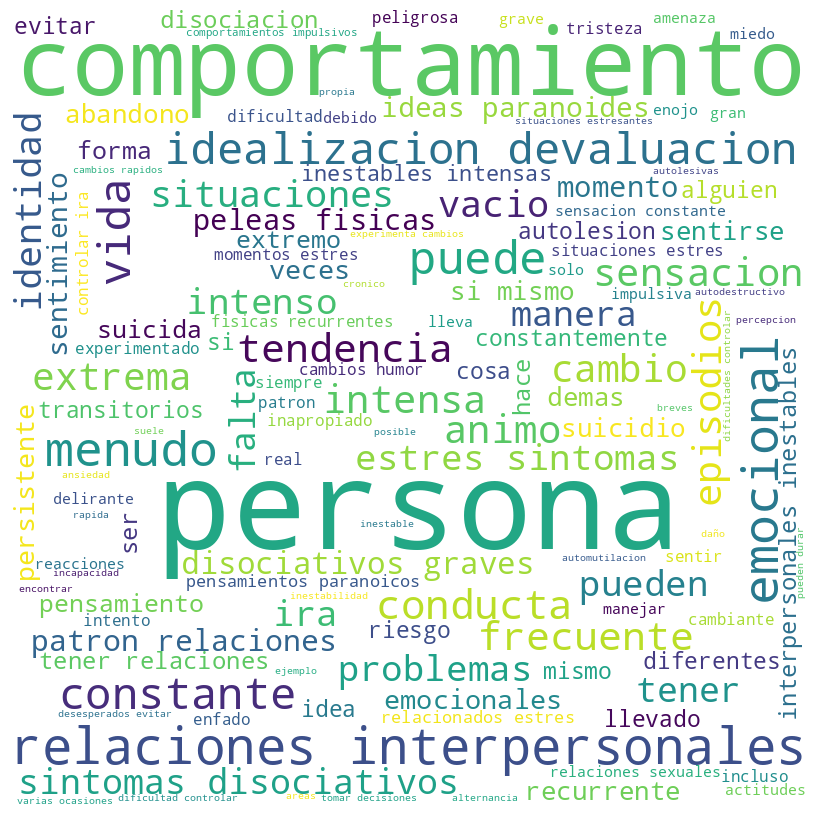

In [46]:
nube_palabras(stopwords_by_cat(data, 1))

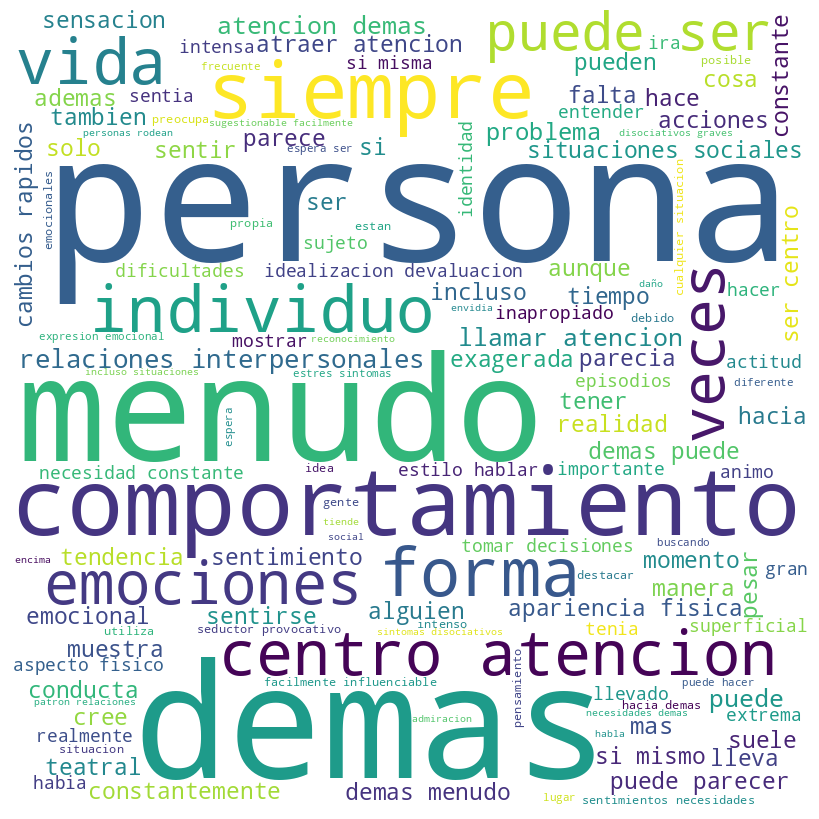

In [47]:
all_text = ' '.join(list(data["Sintoma_Limpia"].values))
nube_palabras(all_text)
del all_text

# FineTuning
- Conversión de pandas a dataset(hugginface)
- Renombre de las columnas adecuedas
- Split train-test de los datos


In [48]:
dataset = Dataset.from_pandas(data)
dataset = dataset.rename_column("Sintoma_Limpia", "text")
dataset = dataset.rename_column("Padecimiento_Cat", "label")

In [49]:
dataset = dataset.train_test_split(test_size=0.1)
dataset

DatasetDict({
    train: Dataset({
        features: ['Síntoma', 'Padecimiento', 'label', 'text'],
        num_rows: 901
    })
    test: Dataset({
        features: ['Síntoma', 'Padecimiento', 'label', 'text'],
        num_rows: 101
    })
})

## Carga de los modelos
-  Carga dccuchile/bert-base-spanish-wwm-cased
-  Preparación de los paramestros de entrenamiento
-  Entrenamiento
-  Guarda de los modelos de entrenamientos


Carga del modelo ber en español

In [50]:
model_id="dccuchile/bert-base-spanish-wwm-cased"

In [51]:
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [52]:
def tokenize_function(examples):
  return tokenizer(examples["text"], padding="max_length", truncation=True)

In [53]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/901 [00:00<?, ? examples/s]

Map:   0%|          | 0/101 [00:00<?, ? examples/s]

In [57]:
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=target_nro, id2label=id2label, label2id=label2id)

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchi

In [58]:
metric = evaluate.load("accuracy")

In [55]:
def compute_metrics(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)
  return metric.compute(predictions=predictions, references=labels)

In [59]:
from transformers import TrainingArguments
training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

In [60]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
)

In [61]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.163176,0.950495
2,No log,0.250473,0.950495
3,No log,0.181913,0.970297


TrainOutput(global_step=339, training_loss=0.2640081309990897, metrics={'train_runtime': 262.4615, 'train_samples_per_second': 10.299, 'train_steps_per_second': 1.292, 'total_flos': 711208339080192.0, 'train_loss': 0.2640081309990897, 'epoch': 3.0})

In [62]:
trainer.evaluate(tokenized_datasets["test"])

{'eval_loss': 0.1819125860929489,
 'eval_accuracy': 0.9702970297029703,
 'eval_runtime': 3.5003,
 'eval_samples_per_second': 28.855,
 'eval_steps_per_second': 3.714,
 'epoch': 3.0}

In [63]:
index = 1
tokenized_datasets["test"][index]["Síntoma"], tokenized_datasets["test"][index]["label"]

('Ideas delirantes transitorias asociadas al estrés o a síntomas disociativos graves.',
 1)

In [64]:
predict= trainer.predict(tokenized_datasets["test"])

In [65]:
preds = np.argmax(predict.predictions, axis=-1)

In [66]:
df_evaluate = pd.DataFrame(tokenized_datasets["test"] ) 
df_evaluate['prediction'] = preds

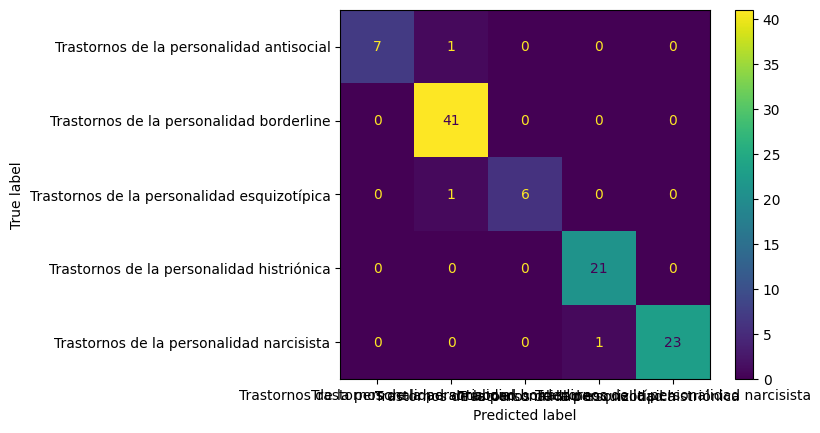

In [67]:
confusion_matrix = metrics.confusion_matrix(df_evaluate['label'], df_evaluate['prediction'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = labelencoder.classes_)
cm_display.plot()
plt.show()

In [68]:
model_id_custom = "./diagnotico_fine_tunning_transformer"
# Save tokenizer
tokenizer.save_pretrained(model_id_custom)
# Save model
trainer.save_model(model_id_custom)

# Testing Model

In [69]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id_custom)
# Load model
loaded_model = AutoModelForSequenceClassification.from_pretrained(model_id_custom)

In [70]:
from transformers import pipeline

In [71]:
classifier = pipeline("text-classification", model=model_id_custom )

In [92]:
text = ["Gasta más dinero de lo que tiene, a menudo, su falta de control hace que esté en deudas", "Le gusta estar solo y le molesta la gente a su alrededor, solo piensa en él",
       "Tiene pocas habilidades sociales, ignora normas de convivencia", "Siempre que está en falta, culpa a los demás de sus problemas" ]

In [91]:
classifier(text[2])

[{'label': 'Trastornos de la personalidad esquizotípica',
  'score': 0.9714377522468567}]

# XAI Model

In [83]:
%%capture
!pip install captum

In [84]:
import torch
import pandas as pd

from torch import tensor 

from transformers.pipelines import TextClassificationPipeline
from captum.attr import LayerIntegratedGradients, TokenReferenceBase

import matplotlib.pyplot as plt

class ExplainableTransformerPipeline():
    """Wrapper for Captum framework usage with Huggingface Pipeline"""
    
    def __init__(self, name:str, pipeline: TextClassificationPipeline, device: str):
        self.__name = name
        self.__pipeline = pipeline
        self.__device = device
    
    def forward_func(self, inputs: tensor, position = 0):
        """
            Wrapper around prediction method of pipeline
        """
        pred = self.__pipeline.model(inputs,
                       attention_mask=torch.ones_like(inputs))
        return pred[position]
        
    def visualize(self, inputs: list, attributes: list, prediction: dict):
        """
            Visualization method.
            Takes list of inputs and correspondent attributs for them to visualize in a barplot
        """
        attr_sum = attributes.sum(-1) 
        
        attr = attr_sum / torch.norm(attr_sum)
        
        a = pd.Series(attr.numpy()[0], 
                         index = self.__pipeline.tokenizer.convert_ids_to_tokens(inputs.detach().numpy()[0]))
        
        predicted_label = prediction[0]["label"]

        plt.title(predicted_label)
        
        plt.show(a.plot.barh(figsize=(10,5)))
                      
    def explain(self, text: str):
        """
            Main entry method. Passes text through series of transformations and through the model. 
            Calls visualization method.
        """
        prediction = self.__pipeline.predict(text)
        inputs = self.generate_inputs(text)
        baseline = self.generate_baseline(sequence_len = inputs.shape[1])
        
        lig = LayerIntegratedGradients(self.forward_func, self.__pipeline.model.bert.embeddings)

        label2id = self.__pipeline.model.config.label2id[prediction[0]['label']] 
        label2id = int(label2id)
        attributes, delta = lig.attribute(inputs=inputs,
                                  baselines=baseline,
                                  target = label2id, 
                                  return_convergence_delta = True)
        
        
        
        self.visualize(inputs, attributes, prediction)
        
    def generate_inputs(self, text: str) -> tensor:
        """
            Convenience method for generation of input ids as list of torch tensors
        """
        return torch.tensor(self.__pipeline.tokenizer.encode(text, add_special_tokens=False), device = self.__device).unsqueeze(0)
    
    def generate_baseline(self, sequence_len: int) -> tensor:
        """
            Convenience method for generation of baseline vector as list of torch tensors
        """        
        return torch.tensor([self.__pipeline.tokenizer.cls_token_id] + [self.__pipeline.tokenizer.pad_token_id] * (sequence_len - 2) + [self.__pipeline.tokenizer.sep_token_id], device = self.__device).unsqueeze(0)
    

In [87]:
device = "cpu"
exp_model = ExplainableTransformerPipeline(model_id_custom, classifier, device)

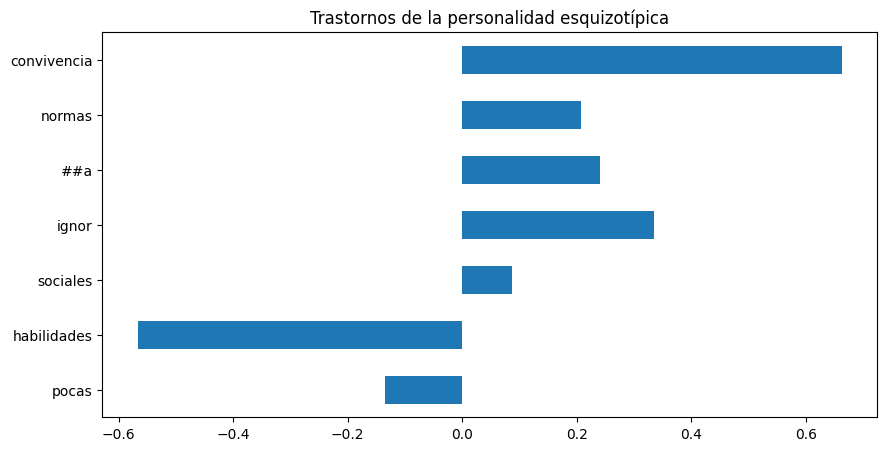

In [94]:
sample = clean_text(text[2])
exp_model.explain(sample)